<a href="https://colab.research.google.com/github/LeejwUniverse/basic_transformer/blob/main/basic_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import json

import torch
import torch.nn as nn
import torch.nn.functional as F

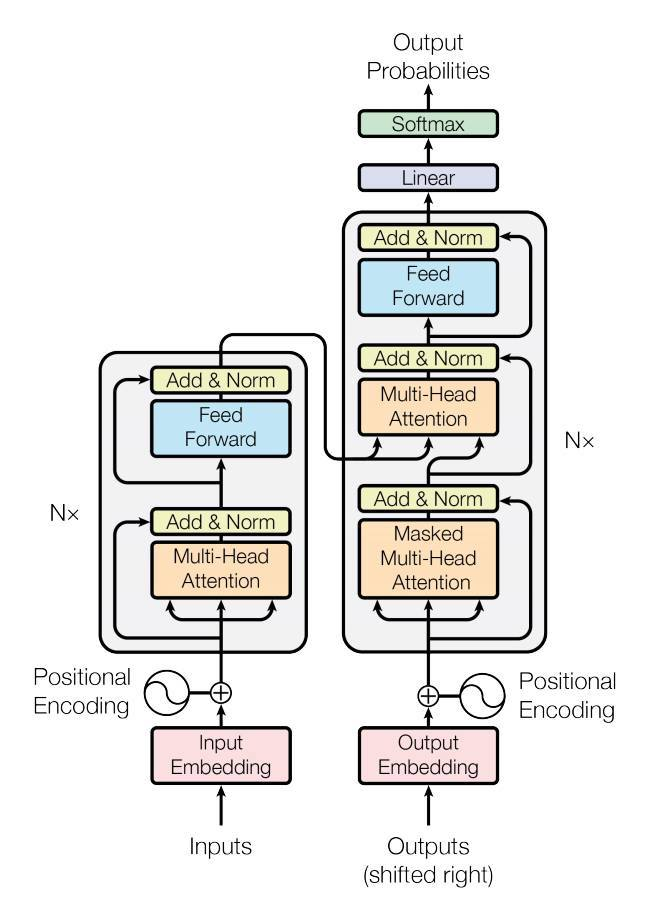

# **1. Positional Encoding**

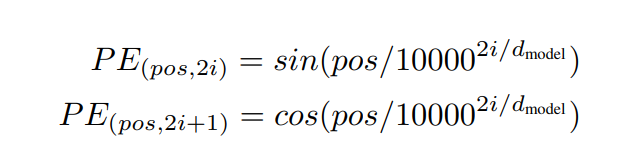

In [2]:
"""sinusoid positional encoding"""
def sinusoid_positional_encoding(n_seq, d_model):
  sinusoid = np.array([[pos / np.power(10000, 2 * (index // 2) / d_model) for index in range(d_model)] for pos in range(n_seq)])
  ## 64 시퀀스, 128 model_hidden size. (index//2)인 이유는 0,1이 index로 들어가면 0/2 = 0 , 1/2 = 0.5 몫만 취하므로 둘다 0임 하지만 sin,cos번갈아가기 때문에
  ## 각 sin, cos함수에서 순서대로 짝수들이 0: 0, 1: 2, 2: 4 | 홀수들이 0: 1, 1: 3, 2: 5와 같이 계산된다.(앞에 숫자들이 함수의 순서, 뒤에 숫자들이 실제 sinusoid table index)
  
  sinusoid[:, 0::2] = np.sin(sinusoid[:, 0::2]) ## 짝수 column 계산 0,2,4,6,8 
  sinusoid[:, 1::2] = np.cos(sinusoid[:, 1::2]) ## 홀수 column계산 1,3,5,7,9
  
  return sinusoid

In [3]:
print(sinusoid_positional_encoding(10,128).shape)
# 10: 아이템 시퀀스 갯수 item 0 - item 1 ... - item 10
# 128: 각 아이템의 위치를 128 vector로 표현한다.

(10, 128)


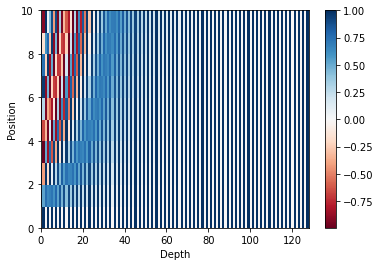

In [5]:
n_seq = 10
d_hidn = 128
pos_encod = sinusoid_positional_encoding(n_seq, d_hidn)

plt.pcolormesh(pos_encod, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_hidn))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# x축 0:sin 1:cos 2:sin 3:cos ... 반복

# **2. masking 함수**

self-attention을 위한 masking

In [6]:
def get_attention_padd_mask(seq_q, seq_k, i_pad): ## self.attention을 위한 masking
  batch_size, len_q = seq_q.size()
  batch_size, len_k = seq_k.size()
  pad_attention_mask = seq_k.data.eq(i_pad).unsqueeze(1).expand(batch_size, len_q, len_k) # 0이 있을 경우 True, True의 의미는 추후에 masking을 해줘야하는 자리.
  
  return pad_attention_mask # True, False 값을 가짐.

decoder는 추가로 decoder의 성질을 반영하기 위해 upper triangle 자리를 masking 처리 해줘야 한다.
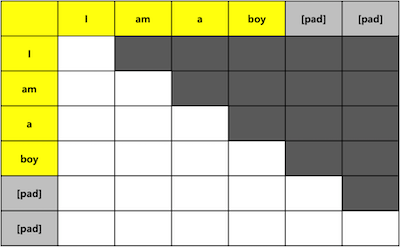

In [7]:
def decoder_get_attention_padd_mask(seq): ## decoder의 attention mask,
  subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
  subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D), upper triangular만 1로 채움
  
  return subsequent_mask # 0,1의 값을 가짐

# **3. Attention**
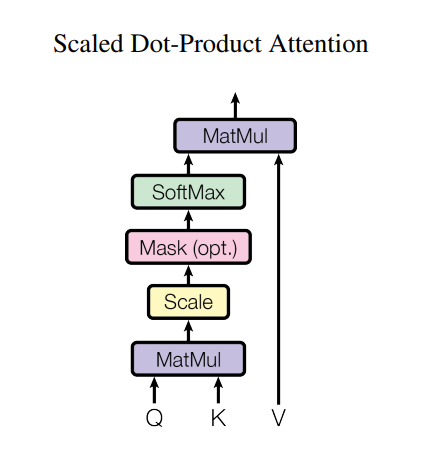

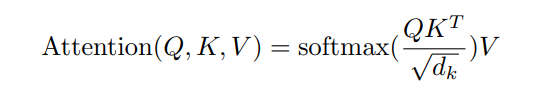

In [8]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(config['dropout'])
        self.sqrt_d_k = 1 / (self.config['d_head'] ** 0.5)
        self.softmax = nn.Softmax(dim=-1) ## softmax 선언
    
    def forward(self, Q, K, V, attn_mask):
        "Q, K matmul part"
        scores = torch.matmul(Q, K.transpose(-1, -2))
        "Scale part"
        scores = torch.mul(scores, self.sqrt_d_k)
        "mask (opt) part"
        scores.masked_fill_(attn_mask, -1e9) ## attention masking 해주기.
        "softmax part"
        attn_prob = self.softmax(scores) ## softmax 값 구하기.
        attn_prob = self.dropout(attn_prob) ## dropout 0.2 걸어주기.
        "matmul part"
        attn_result = torch.matmul(attn_prob, V) ## matrix multiplication softmax * V
        
        return attn_result, attn_prob ## 

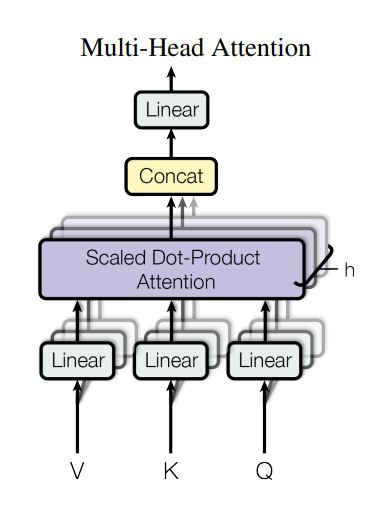

In [25]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.W_Q = nn.Linear(self.config['d_hidn'], self.config['n_head'] * self.config['d_head'])
        self.W_K = nn.Linear(self.config['d_hidn'], self.config['n_head'] * self.config['d_head'])
        self.W_V = nn.Linear(self.config['d_hidn'], self.config['n_head'] * self.config['d_head'])
        self.scaled_dot_attn = ScaledDotProductAttention(self.config)
        self.linear = nn.Linear(self.config['n_head'] * self.config['d_head'], self.config['d_hidn'])
        self.dropout = nn.Dropout(config['dropout'])
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        "Q, K, V liner part"
        QW_Q = self.W_Q(Q).view(batch_size, -1, self.config['n_head'], self.config['d_head']).transpose(1,2)
        KW_K = self.W_K(K).view(batch_size, -1, self.config['n_head'], self.config['d_head']).transpose(1,2)
        VW_V = self.W_V(V).view(batch_size, -1, self.config['n_head'], self.config['d_head']).transpose(1,2)
      
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config['n_head'], 1, 1) # (bs, n_head, n_q_seq, n_k_seq)
                                                                                  # attention masking.
                                                                                  # 원래 (bs, n_q_seq, n_k_seq) 였던 것을 (bs, 1, n_q_seq, n_k_seq)로 차원 늘려주고,
                                                                                  # multi attention head에 맞게 (bs, n_head, n_q_seq, n_k_seq)로 늘려줌.
        "scaled dot-product attention part"
        attn_result, attn_prob = self.scaled_dot_attn(QW_Q, KW_K, VW_V, attn_mask) # (bs, n_head, n_q_seq, n_k_seq)
                                                                                   # masking 되고 쪼개진 q, k, v를 attention score 계산해줌.
        
        "concat part"
        attn_result = attn_result.transpose(1, 2).contiguous().view(batch_size, -1, self.config['n_head'] * self.config['d_head']) # (bs, n_q_seq, h_head * d_head) = (bs, n_q_seq, d_hidn)
                                                                                                                                   # attention 계산이 끝난후 다시 embedding hidden으로 차원 변경.
        "linear part"
        output = self.linear(attn_result)
        output = self.dropout(output)
       
        
        return output, attn_prob  # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)

4. Position-wise Feed-Forward Networks

(batch size, sequence length, embedding hidden)일 경우, 각 sequence position 별로 Fully connected 연산을 하기 때문에 

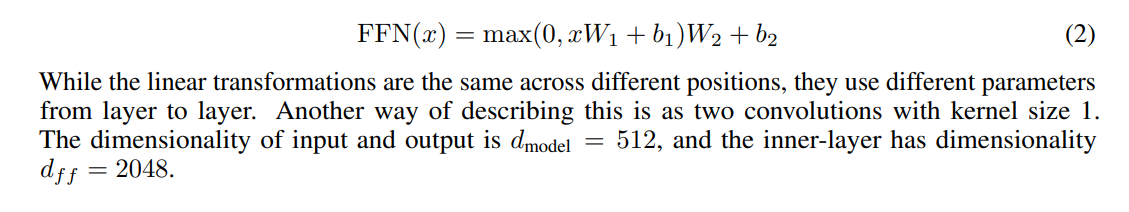

In [18]:
class PoswiseFeedForward(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config
    self.conv1 = nn.Conv1d(in_channels=self.config['d_hidn'], out_channels=self.config['d_ff'], kernel_size=1) # embedding hidden = channel 갯수 -> fully connected channel로 upscale 진행.
    self.conv2 = nn.Conv1d(in_channels=self.config['d_ff'], out_channels=self.config['d_hidn'], kernel_size=1)
    self.dropout = nn.Dropout(config['dropout'])

  def forward(self, inputs):
    output = F.relu(self.conv1(inputs.transpose(1,2)))
    output = self.conv2(output).transpose(1,2)
    output = self.dropout(output)

    return output

In [11]:
class Encoder_module(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.self_attn = MultiHeadAttention(self.config)
    self.layer_norm1 = nn.LayerNorm(self.config['d_hidn'], eps=self.config['layer_norm_epsilon'])
    self.pos_ff = PoswiseFeedForward(self.config)
    self.layer_norm2 = nn.LayerNorm(self.config['d_hidn'], eps=self.config['layer_norm_epsilon'])

  def forward(self, inputs, attn_mask):
    print(inputs.size())

    attn_result, attn_prob = self.self_attn(inputs, inputs, inputs, attn_mask)
    mid_outputs = self.layer_norm1(inputs + attn_result) ## residual + attention_output 결과 먼저 + 연산 후에 layerNorm에 넣음.

    pos_ff_outputs = self.pos_ff(mid_outputs)
    enc_layer_outputs = self.layer_norm2(pos_ff_outputs + mid_outputs)

    return enc_layer_outputs, attn_prob

In [36]:
class Encoder(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.enc_emb = nn.Embedding(self.config['n_enc_items'], self.config['d_hidn'])
    sinusoid_table = torch.FloatTensor(sinusoid_positional_encoding(self.config['n_enc_seq'] + 1, self.config['d_hidn']))
    self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True) # freeze=True not learnable. positional embedding은 학습되지 않음.
    self.layers = nn.ModuleList([Encoder_module(self.config)]) # nn.ModuleList는 nn.Module로 만들어진 class를 list처럼 활용할 수 있게 해줍니다.

  def forward(self, inputs): # (batch, longest sequence length).
    positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1 # (bs, n_enc_seq)
                                                                                                                                               # + 1 하는 이유, 0을 padd token으로 사용해서 제외 해야함. 
    pos_mask = inputs.eq(self.config['i_pad']) # (bs, n_enc_seq), True, False 값
    positions.masked_fill_(pos_mask, 0) # (bs, n_enc_seq) 
                                        # pos_mask의 True부분을 0으로 채워줌.
                                        # True = padd
    
    enc_layer_outputs = self.enc_emb(inputs) + self.pos_emb(positions) # (batch, sequence length, embedding hidden)
                                                                      # encoder 처음 input을 나타냄, output은 코드상 편의성을 위해.
    
    attn_mask = get_attention_padd_mask(inputs, inputs, self.config['i_pad']) # (batch, sequence length, sequence length)
    
    attn_probs = [] # attention score map을 저장하기 위한 list. 각 layer 단계마다 저장.
    for layer in self.layers: # encoder layer의 수대로 for문 반복.
      enc_layer_outputs, attn_prob = layer(enc_layer_outputs, attn_mask) # (batch, sequence length, embedding hidden), (batch, multi_head, sequence length, sequence length)
      attn_probs.append(attn_prob)
    return enc_layer_outputs, attn_probs

In [20]:
class Decoder_module(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config['d_hidn'], eps=self.config['layer_norm_epsilon'])
        self.dec_enc_attn = MultiHeadAttention(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config['d_hidn'], eps=self.config['layer_norm_epsilon'])
        self.pos_ff = PoswiseFeedForward(self.config)
        self.layer_norm3 = nn.LayerNorm(self.config['d_hidn'], eps=self.config['layer_norm_epsilon'])
    
    def forward(self, dec_inputs, enc_outputs, self_attn_mask, dec_enc_attn_mask):
        self_att_outputs, self_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, self_attn_mask) # Q, K, V, self attention mask input으로 들어감.
        self_att_outputs = self.layer_norm1(dec_inputs + self_att_outputs) # 
        
        dec_enc_att_outputs, dec_enc_attn_prob = self.dec_enc_attn(self_att_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_enc_att_outputs = self.layer_norm2(self_att_outputs + dec_enc_att_outputs)
        
        ffn_outputs = self.pos_ff(dec_enc_att_outputs)
        ffn_outputs = self.layer_norm3(dec_enc_att_outputs + ffn_outputs)
        
        return ffn_outputs, self_attn_prob, dec_enc_attn_prob

In [46]:
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.dec_emb = nn.Embedding(self.config['n_dec_items'], self.config['d_hidn'])
        sinusoid_table = torch.FloatTensor(sinusoid_positional_encoding(self.config['n_dec_seq'] + 1, self.config['d_hidn']))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([Decoder_module(self.config) for _ in range(self.config['n_layer'])])
    
    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        positions = torch.arange(dec_inputs.size(1), device=dec_inputs.device, dtype=dec_inputs.dtype).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous() + 1 # (bs, n_dec_seq)
                                                                                                                                                                      # + 1 하는 이유, 0을 padd token으로 사용해서 제외 해야함.
        
        pos_mask = dec_inputs.eq(self.config['i_pad']) # (bs, n_dec_seq) 
                                                      # 0을 padd token으로 사용. 0인 자리는 최대 길이 sequence를 기준으로 item 갯수가 부족한 상황.
        positions.masked_fill_(pos_mask, 0) # (bs, n_dec_seq)
                                            # position 값을 다시 padd에 맞게 수정 합니다.
    
        dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions) # (bs, n_dec_seq, embedding hidden)

        dec_attn_pad_mask = get_attention_padd_mask(dec_inputs, dec_inputs, self.config['i_pad']) ## 기본적인 마스킹 batch로 처리하게되면 user의 item 갯수마다 다를수 있습니다. 가장 긴 sequence를 기준으로 짧은 data는 0으로 padding되는 데 그와 관련된 masking 입니다.
      
        dec_attn_decoder_mask = decoder_get_attention_padd_mask(dec_inputs) ## 디코더를 위한 마스킹

        print(dec_attn_pad_mask)
        print(dec_attn_decoder_mask)
        dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0) ## 0인 자리만 false.
                                                                                      ## length padding masking과 decoder를 위한 masking 결합.
        print(dec_self_attn_mask)
        dec_enc_attn_mask = get_attention_padd_mask(dec_inputs, enc_inputs, self.config['i_pad']) ## 인코더 아웃풋과 디코더 아웃풋들이 만나는 attention에 사용.

        self_attn_probs, dec_enc_attn_probs = [], []
        for layer in self.layers:
            dec_outputs, self_attn_prob, dec_enc_attn_prob = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            self_attn_probs.append(self_attn_prob)
            dec_enc_attn_probs.append(dec_enc_attn_prob)
       
        return dec_outputs, self_attn_probs, dec_enc_attn_probs

In [40]:
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.encoder = Encoder(self.config)
        self.decoder = Decoder(self.config)
    
    def forward(self, enc_inputs, dec_inputs):
        enc_outputs, enc_self_attn_probs = self.encoder(enc_inputs) # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        dec_outputs, dec_self_attn_probs, dec_enc_attn_probs = self.decoder(dec_inputs, enc_inputs, enc_outputs) # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq), (bs, n_head, n_dec_seq, n_enc_seq)
        
        return dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs # (bs, n_dec_seq, n_dec_vocab), (bs, n_head, n_enc_seq, n_enc_seq), (bs, n_head, n_dec_seq, n_dec_seq), (bs, n_head, n_dec_seq, n_enc_seq)

In [47]:
config ={
        "n_enc_items": 1000, # embedding으로 표현할 최대 item 갯수
        "n_dec_items": 1000, # embedding으로 표현할 최대 item 갯수
        "n_enc_seq": 256, # encoder의 최대 sequence 길이
        "n_dec_seq": 256, # decoder의 최대 sequence 길이
        "n_layer": 2, # transformer의 layer 갯수
        "d_hidn": 128, # embedding에 해당하는 hidden 차원 (encoder input, decoder input, position input이 해당됨)
        "i_pad": 0, # padding을 담당할 token의 index
        "d_ff": 1024, # fully-connected hidden 차원
        "n_head": 4, # multi head의 갯수
        "d_head": 32, # 각 head 마다의 hidden 차원, embedding hidden을 나누는 과정이기 때문에 d_hidn = n_head * d_head로 맞춰 줘야 합니다.
        "dropout": 0.1,
        "layer_norm_epsilon": 1e-12
    }
transformer = Transformer(config)

In [50]:
encoder_input = torch.randint(0,2, (2, 10)) # (batch_size, items)
decoder_input = torch.randint(0,2, (2, 10)) # (batch_size, items)
print(encoder_input)
print(decoder_input)
dec_outputs = transformer(encoder_input,decoder_input)

tensor([[1, 0, 0, 0, 1, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 0, 0]])
tensor([[1, 1, 1, 1, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 1]])
torch.Size([2, 10, 128])
pre torch.Size([2, 10, 10])
post torch.Size([2, 4, 10, 10])
torch.Size([2, 10, 128]) torch.Size([2, 4, 10, 10])
tensor([[[False, False, False, False,  True, False, False,  True, False, False],
         [False, False, False, False,  True, False, False,  True, False, False],
         [False, False, False, False,  True, False, False,  True, False, False],
         [False, False, False, False,  True, False, False,  True, False, False],
         [False, False, False, False,  True, False, False,  True, False, False],
         [False, False, False, False,  True, False, False,  True, False, False],
         [False, False, False, False,  True, False, False,  True, False, False],
         [False, False, False, False,  True, False, False,  True, False, False],
         [False, False, False, False,  True, False, F

In [5]:
torch.arange(10,dtype=torch.int).expand(2, 10).contiguous() + 1 

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]], dtype=torch.int32)